In [ ]:
import os.path as op
import mne



subject = 'training1'  #for debugging
#TODO: move this stuff
#data_path = r'Z:\Real_data\Exp1\%s\meg' % subject
raw_fname = r'C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\data\training_raw-1.fif'
subjects_dir = r'C:\Users\JensenO\Dropbox\FLUX\data\subjects'







Explain Freesurfwer

my_recon.sh

Run the following command in a terminal:
    > recon-all -i SA101.nii -s SA101 -all
    For more info, go to https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all/
    
 
 

 Also in recon: 
 Scalp surface reconstruction
    
    Run the following commands in a terminal (requires FreeSurfer):
    > mne make_scalp_surfaces --overwrite --subject SA101 --force



 Also in recom. Create BEM
    
    To create the BEM, run in a terminal (requires FreeSurfer):
    > mne watershed_bem --overwrite --subject ${file}
    


 Now read and illustrate the brain surface generated from FreeSurfer:
 
 

In [6]:
Brain = mne.viz.get_brain_class()


brain = Brain(subject, 
                  hemi='lh', 
                  surf='pial',
                  subjects_dir=subjects_dir, 
                  size=(800, 600))
%matplotlib qt 
brain.add_annotation('aparc.a2009s', borders=False)


Prepare single shell BEM: 



In [19]:
 # Create BEM model
conductivity = (0.3,)  # for single layer
    # conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject,
                           ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.22 -26.75  24.03 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Now save the BEM model

In [10]:
fname_bem = '%s-bem-sol.fif' % subject
mne.write_bem_solution(op.join(subjects_dir,fname_bem),
                           bem,
                           overwrite=True)
    # To visualize the BEM:


and visualize

Using surface: C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\bem\inner_skull.surf
Using surface: C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\bem\outer_skull.surf
Using surface: C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\bem\outer_skin.surf


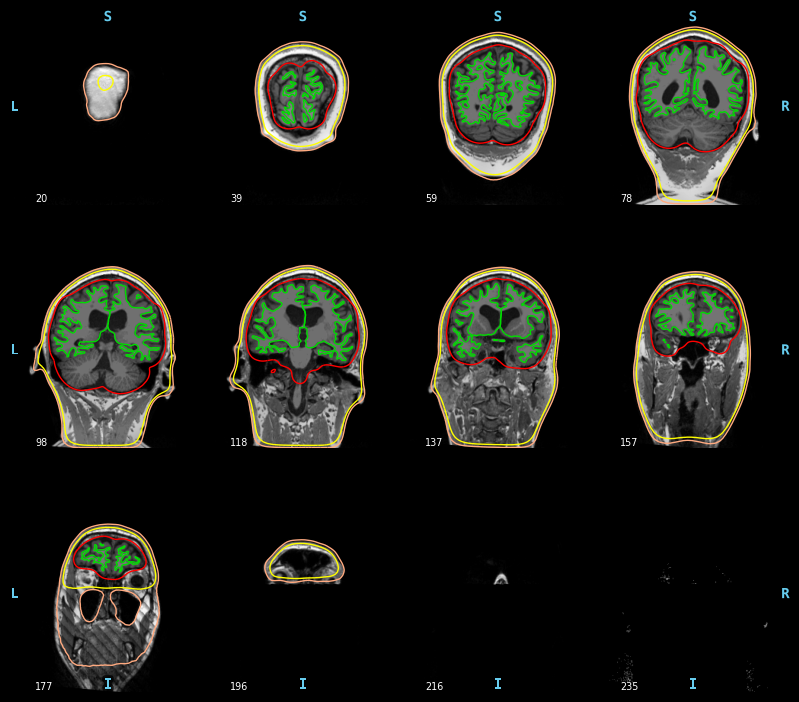

In [12]:
mne.viz.plot_bem(subject=subject,
                subjects_dir=subjects_dir,
                brain_surfaces='white',
                orientation='coronal')

Co-registration 

 Tutorial: https://www.slideshare.net/mne-python/mnepython-coregistration

In [3]:
mne.gui.coregistration()

    Triangle neighbors and vertex normals...
    Triangle neighbors and vertex normals...
Coregistration: Excluding 0 head shape points with distance >= inf m.
Coregistration: Excluding 55 head shape points with distance >= 0.010 m.


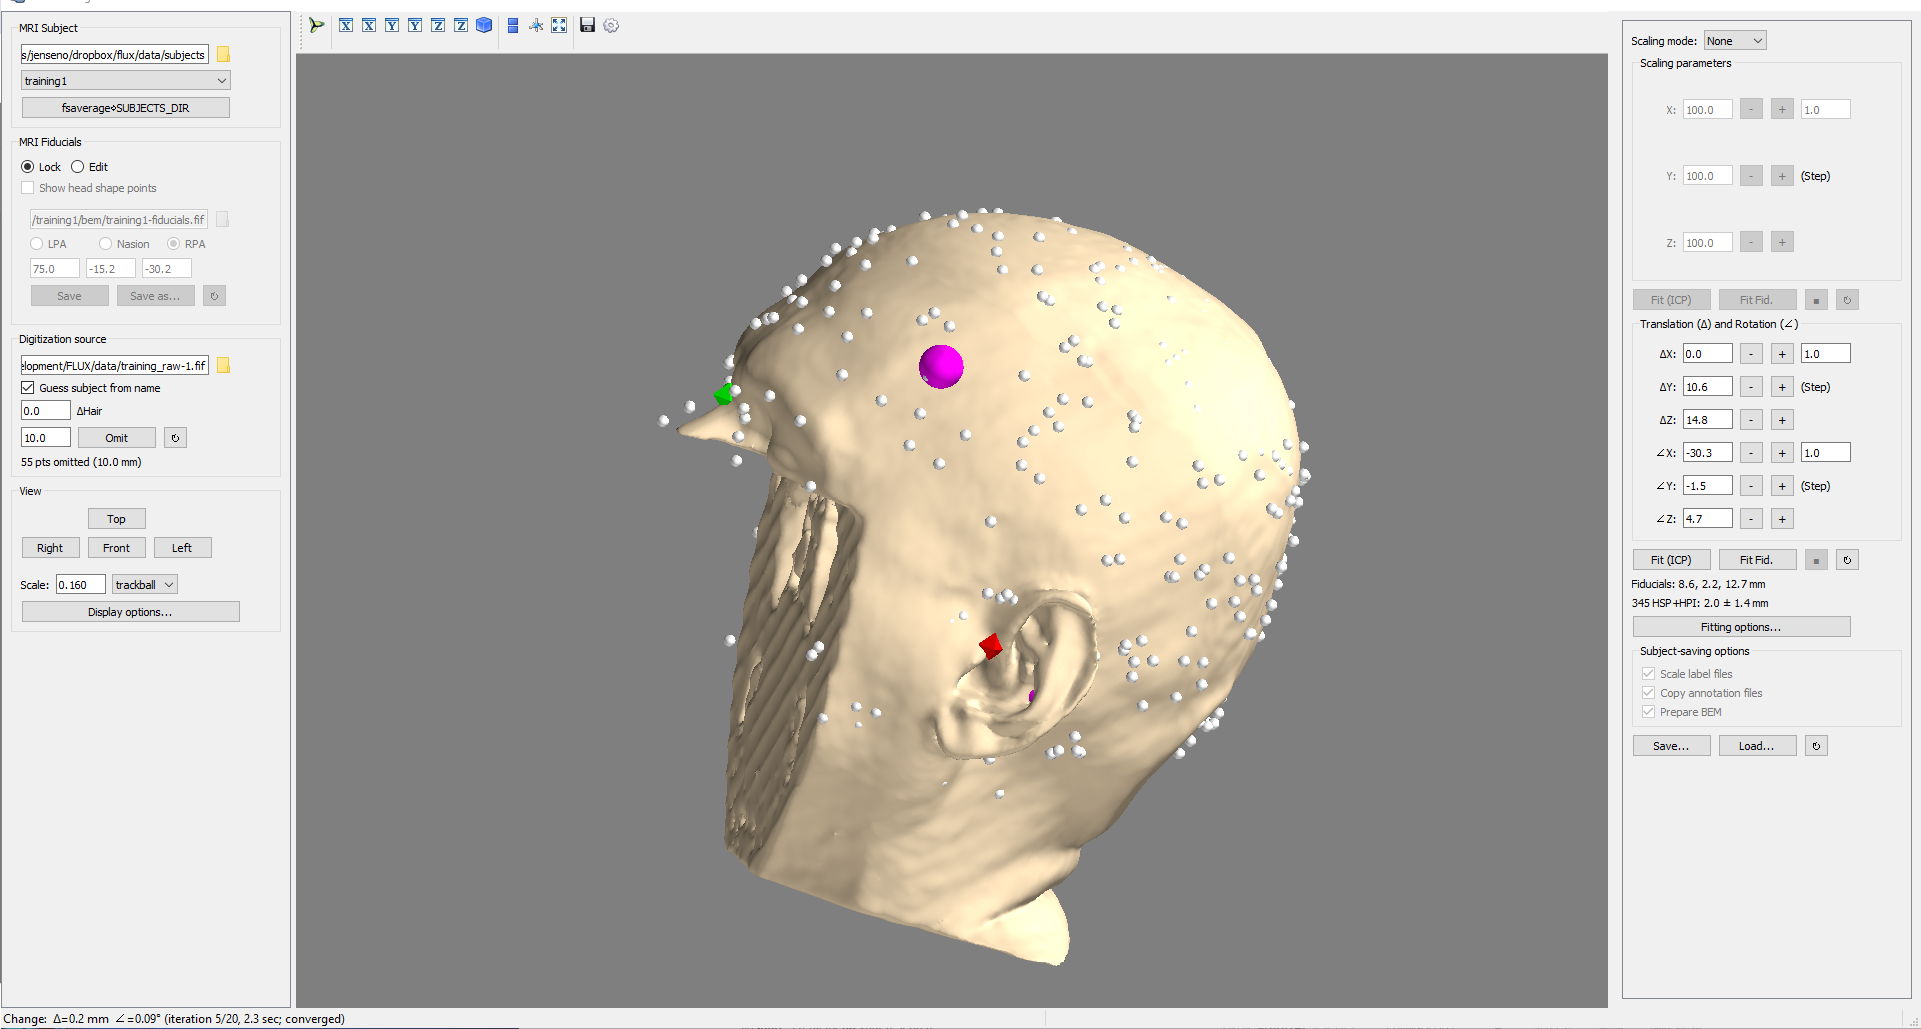

Show results of realing

In [12]:
trans = r'C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\data\training1-trans.fif'
info = mne.io.read_info(raw_fname)
%matplotlib inline
mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                           meg=['helmet', 'sensors'], subjects_dir=subjects_dir,
                           surfaces='head-dense')

    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
Using lh.seghead for head surface.
Getting helmet for system 306m


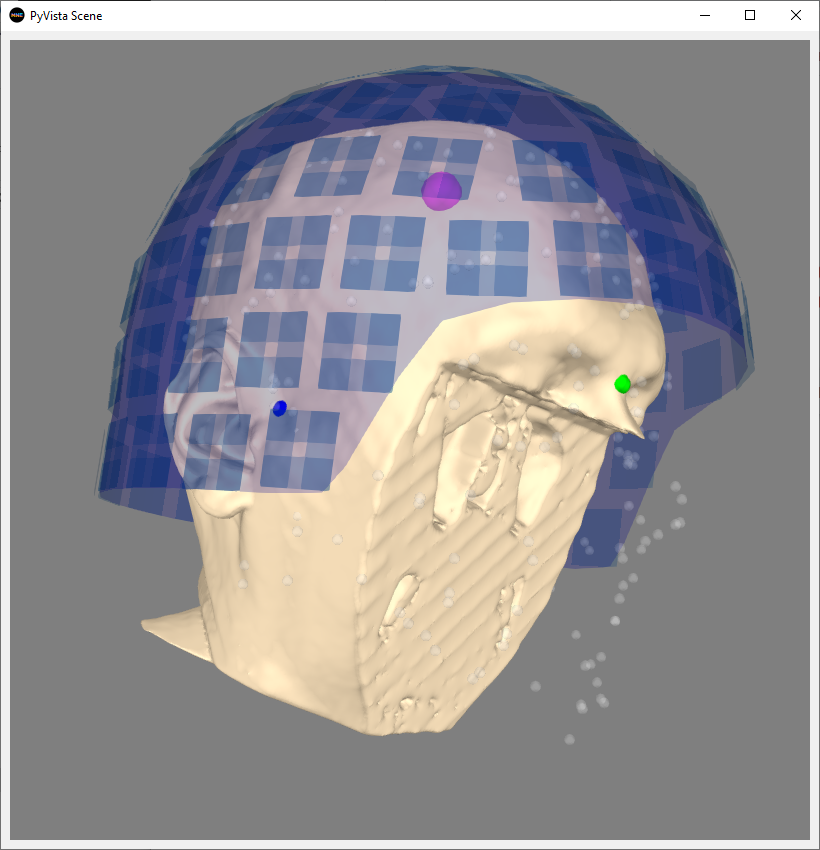

Compute the source space

In [13]:
# Get surface-based source space
spacing='oct6'  # 4098 sources per hemisphere, 4.9 mm spacing
src = mne.setup_source_space(subject,
            spacing=spacing,
            add_dist='patch',
            subjects_dir=subjects_dir)
# Set filename
fname_src = '%s-surface%s_src.fif' % (subject, spacing)


# volume
#  surface = op.join(subjects_dir, subject, 
#                          'bem', 'inner_skull.surf')
#        src = mne.setup_volume_source_space(subject, 
#                                            subjects_dir=subjects_dir,
#                                            surface=surface,
#                                            # mri=mrifile,  #TODO: what is it needed for? For interpolation. Is it required??? Note that MRI can only be .mgh or .mgz
#                                            # mindist=2.5,  #TODO: check these settings
#                                            # exclude=10.0, 
#                                            verbose=True)
#       # Set filename
#        fname_src = '%s-volume_src.fif' % (subject)



Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\JensenO\Dropbox\FLUX\data\subjects
Subject      = training1
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\surf\lh.white...
Mapping lh training1 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/136119 selected to source space (oct = 6)

Loading C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\surf\rh.white...
Mapping rh training1 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/137489 selected to

Adn write

In [16]:
mne.write_source_spaces(op.join(subjects_dir,fname_src),
                            src,
                            overwrite=True)

Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


And visualize


Using surface: C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\bem\inner_skull.surf
Using surface: C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\bem\outer_skull.surf
Using surface: C:\Users\JensenO\Dropbox\FLUX\data\subjects\training1\bem\outer_skin.surf


C:\Users\JensenO\Anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


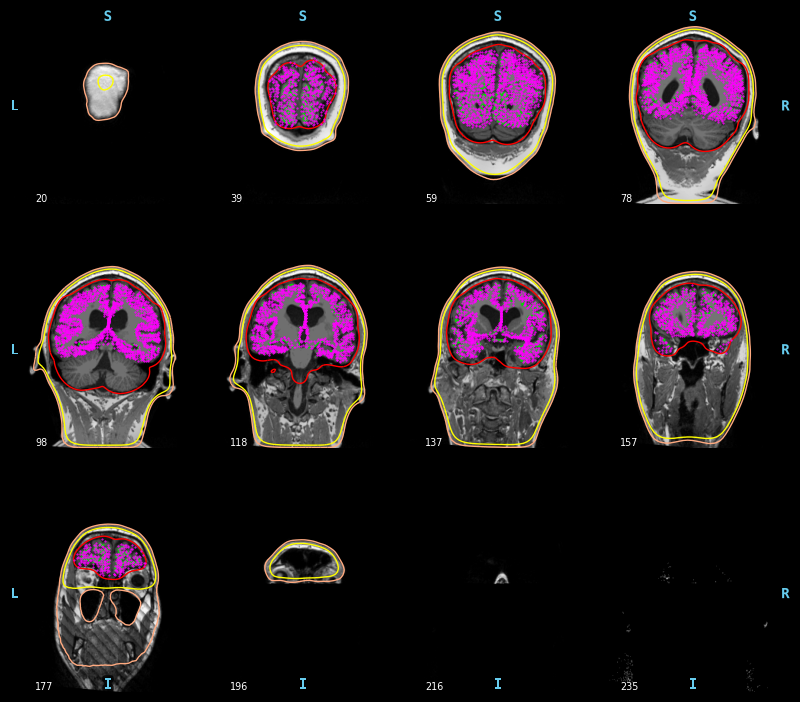

In [17]:
mne.viz.plot_bem(subject=subject, 
                     subjects_dir=subjects_dir,
                     brain_surfaces='white', 
                     src=src, 
                     orientation='coronal');

And make forward model

In [20]:
fwd = mne.make_forward_solution(raw_fname, 
                                    trans=trans, 
                                    src=src, 
                                    bem=bem,
                                    meg=True, eeg=False, 
                                    mindist=5.,  #TODO: minimum distance of sources from inner skull surface (in mm); can be 2.5
                                    verbose=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=136119, n_used=4098>, <surface (rh), n_vertices=137489, n_used=4098>] MRI (surface RAS) coords, subject 'training1', ~25.2 MB>
MRI -> head transform : C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\data\training1-trans.fif
Measurement data      : training_raw-1.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.996247 -0.058107 -0.064149       0.04 mm
     0.082510  0.861462  0.501074      10.55 mm
     0.026146 -0.504486  0.863024      14.78 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.995222 -0.089575 -0.038852      -1.12 mm
     0.095761  0.973127  0.209411      -7.35 mm
     0.019051 -0.212131  0.

now write it

In [23]:
fname_fwd = op.join(subjects_dir,
                        subject+'-surface_fwd.fif' )

mne.write_forward_solution(fname_fwd,
                               fwd,
                               overwrite=True)
    # Number of vertices
print(f'\nNumber of vertices:  {fwd["src"]}')
    # Leadfield size
leadfield = fwd['sol']['data']
print("\nLeadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written

Number of vertices:  <SourceSpaces: [<surface (lh), n_vertices=136119, n_used=4097>, <surface (rh), n_vertices=137489, n_used=4098>] head coords, subject 'training1', ~25.2 MB>

Leadfield size : 306 sensors x 24585 dipoles
